# Calculations with linear-scaling BigDFT code
In this tutorial we will build upon the cubic scaling tutorial to show how to run the linear scaling (LS) version of BigDFT. We are going to use the same .xyz files for water that we used for cubic scaling BigDFT.

LS-BigDFT can only use semi-local functionals (no hybrid functionals), so for the purposes of this tutorial we will stick with using PBE. 
We will focus on the comparison of performance between the CS and the LS version for systems which are compatible with both algorithms.

## Remote calculation of a dataset of different runs of the water molecule
We can use the function from the cubic scaling notebook as inspiration, but since we will be modifying more input parameters than in the cubic scaling case, we define the function to recieve the input dictionary as an argument, to allow greater flexibility.
The `Inputfile` class can be handled by the methods which are described in [this](https://l_sim.gitlab.io/bigdft-suite/PyBigDFT/build/html/BigDFT.InputActions.html) page.

In [1]:
def calculate_single_point(run_name, filename, inp, run_directory='Calculations'):
    from BigDFT import Calculators as C
    from futile.Utils import create_tarball
    from os.path import join
    from os.path import isfile

    # create the calculator
    code = C.SystemCalculator(skip=True)
    # launch the calculation and retrieve the logfile instance
    log = code.run(input=inp, name=run_name, posinp=filename, run_dir=run_directory)
    # we create a tarfile that contains the logfile as well as the information about the timing
    files = [join(run_directory,'log-'+run_name+'.yaml')]
    for timefile in [join(run_directory,'data-'+run_name,'time-'+run_name+'.yaml'),
                     join(run_directory,'time-'+run_name+'.yaml')]:
        if isfile(timefile):
            files += [timefile]
            break
    create_tarball(run_name+'.tar.gz', files=files)
    
    # return the energy
    return log.energy

As with cubic scaling BigDFT, we now create a dataset of remote functions to execute the pool of jobs into Vega, from this notebook. In order to save rerunning the cubic scaling calculations, we also keep the same directories as before.

In [2]:
#if you are in a Google colab session
try:
    from google.colab import drive
    in_colab = True
except:
    in_colab = False
print('We are in a google colab session: ',in_colab)
if in_colab:
    import subprocess
    print(subprocess.check_output(['pip', 'install', '-U','pybigdft','pyfutile','py3Dmol','remotemanager']))

We are in a google colab session:  True
b'Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/\nCollecting pybigdft\n  Downloading pybigdft-1.0.3-py3-none-any.whl (588 kB)\nCollecting pyfutile\n  Downloading pyfutile-1.9.3-py3-none-any.whl (56 kB)\nCollecting py3Dmol\n  Downloading py3Dmol-1.8.1-py2.py3-none-any.whl (6.5 kB)\nCollecting remotemanager\n  Downloading remotemanager-0.3.4-py3-none-any.whl (53 kB)\nRequirement already satisfied: scipy in /usr/local/lib/python3.7/dist-packages (from pybigdft) (1.7.3)\nRequirement already satisfied: numpy in /usr/local/lib/python3.7/dist-packages (from pybigdft) (1.21.6)\nRequirement already satisfied: pyyaml in /usr/local/lib/python3.7/dist-packages (from pybigdft) (6.0)\nInstalling collected packages: remotemanager, pyfutile, pybigdft, py3Dmol\nSuccessfully installed py3Dmol-1.8.1 pybigdft-1.0.3 pyfutile-1.9.3 remotemanager-0.3.4\n'


In [4]:
if in_colab:
  from remotemanager import URL
  url = URL()
else:
  # import the vega URL from the previous notebook
  import yaml
  from remotemanager.connection.computers import Vega
  with open('vega.yaml') as ifile:
      vega_spec=yaml.load(ifile,Loader=yaml.Loader)
  url = Vega(host='vega')
  for attribute, value in vega_spec.items():
      setattr(url, attribute, value)

Now let's set up a loop over two calculations - linear is true and false (i.e. cubic scaling).

You will notice that running LS-BigDFT only requires a single change to the input file - this is because we are loading a _profile_, which itself sets a number of parameters relating to LS-BigDFT. Depending on the system and properties you are interested in calculating, you may need to make further changes, as we will see below, but for many scenarios this set of parameters is already robust enough and sufficient to run a single point calculation.

In [5]:
user = 'eugenovesel'

In [52]:
!wget https://raw.githubusercontent.com/BigDFT-group/bigdft-school/main/packaging/install.py 2> /dev/null
import install
if in_colab:
  install.data('data/H2O-LS.tar.xz')

Executing: wget https://gitlab.com/luigigenovese/bigdft-school/-/raw/main/data/H2O-LS.tar.xz -O H2O-LS.tar.xz
--2022-11-16 19:57:41--  https://gitlab.com/luigigenovese/bigdft-school/-/raw/main/data/H2O-LS.tar.xz
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 458572 (448K) [application/octet-stream]
Saving to: ‘H2O-LS.tar.xz’

     0K .......... .......... .......... .......... .......... 11% 13.7M 0s
    50K .......... .......... .......... .......... .......... 22% 13.7M 0s
   100K .......... .......... .......... .......... .......... 33% 55.7M 0s
   150K .......... .......... .......... .......... .......... 44% 39.1M 0s
   200K .......... .......... .......... .......... .......... 55% 25.6M 0s
   250K .......... .......... .......... .......... .......... 66% 45.9M 0s
   300K .......... .......... .......... .........

In [22]:
from os.path import join, relpath
from BigDFT import Inputfiles as I
from remotemanager import Dataset
local_dir = 'H2O-linear-single'
remote_dir = f'/ceph/hpc/data/d2021-135-users/bigdft-school/{user}/H2O-single-LS' #use your own directory for new calculations
force_reinitialization = not in_colab # in case you rerun this cell multiple times
filename = 'H2O-1.xyz'
all_runs = Dataset(function = calculate_single_point,
                   url = url,
                   name = 'H2O-single-LS',
                   remote_dir = remote_dir,
                   local_dir = local_dir,
                   extra_files_send=filename,
                   block_reinit = force_reinitialization)

#we collect the run names for future reuse
run_names = []
# the we append the runs we would like to perform
functional = 'PBE'

for linear in [True, False]:
    #identify a name for the run
    run_name = '-'.join([filename.split('.')[0],functional] + (['linear'] if linear else []))
    
    # create a reasonable set of input parameters for the molecule - these are the same as the cubic scaling case
    inp = I.Inputfile()
    inp.set_xc(functional)
    inp.set_hgrid(0.4)
    inp.set_psp_nlcc()

    # activate the linear scaling mode if required
    if linear:
        inp["import"] = "linear"        
    
    # we then pass the input dictionary to our function
    func_kwargs = dict(run_name=run_name, filename=filename, inp=dict(inp))

    run_args = {}
    run_args['jobname'] = run_name
    run_args['mpi'] = 4
    run_args['omp'] = 4
    run_args['time'] = 2 # minutes
    
    all_runs.append_run(args=func_kwargs, 
                        extra_files_recv=[run_name+'.tar.gz'],
                        **run_args)
    run_names.append(run_name)    


In [23]:
#for slow connections
# all_runs.url.timeout=120
# all_runs.url.max_timeouts=20
# all_runs.url.raise_errors=False #to override ssh error messages

In [25]:
all_runs.run()  # if you want to redo the calculation you can put force=True)

run already completed, skipping
run already completed, skipping
run already completed, skipping


Both runs should be very quick, once they're done we can copy back the results.

In [ ]:
import time
# while not all_runs.all_finished:
#     time.sleep(1)
all_runs.fetch_results(ignore_errors=True)

In [27]:
energies = all_runs.results

We can print out the energy values for reference, as well as the difference in energy - we can see that the LS value is a few mHa higher than the value for the cubic scaling case.

Of course, the total energy itself is often not of interest, and we typically expect the energy error to be smaller when looking at energy differences, due to error cancellation.

In the case where greater accuracy is required, it is also possible to modify the localisation radii which define the regions in which the support functions leave - the larger the radii, the closer to the cubic scaling value, although this typically implies an increase in cost. For the interested party, this is demonstrated in the 2.B notebook of bigdft-school/CCP-tutorials.

In [28]:
print(energies)
print(energies[0] - energies[1])

[-17.601346664765046, -17.60611945369108, -17.60134666476504]
0.004772788926032945


# Analysis of the runs
After those runs have been executed we can compare different quantities among the various runs, for illustrative purposes.
We will highlight:

1. The Density of States
2. The Molecule dipole
3. The profiling of the different timing categories

We start by unpacking the received data

In [29]:
#this is useful in colab
!wget https://raw.githubusercontent.com/BigDFT-group/bigdft-school/main/Enccs_tutorials/analysis.py 2> /dev/null

In [30]:
from analysis import extract_results

In [31]:
# the data are unpacked in a "Calculations" subdirectory (see above arguments)
extract_results('H2O-linear-single')

We read the different logfiles


In [32]:
from BigDFT.Logfiles import Logfile as L
logs = {name.lstrip('H2O-1-'): L(join('H2O-linear-single','Calculations','log-'+name+'.yaml'))
        for name in run_names}

Where we see the localization effect of the Hybrid functional with respect to the energies of the semilocal ones.

## Total Dipole
We can also again print the dipoles - we see here again the similarity between LS and cubic scaling results.

In [33]:
from analysis import dipole_info

In [34]:
from pandas import DataFrame
data = {name: dipole_info(log)for name, log in logs.items()}
table = DataFrame(data).T
table.round(2)

,x (AU),y (AU),z (AU),Norm (Debye)
PBE-linear,0.60,0.34,-0.19,1.83
PBE,0.59,0.34,-0.19,1.78


Here we see the polarizability effect induced by the environment.

## Time to solution
We can also inspect the different timings for this runs, to understand how the computational resources have been used in the different approximations

In [35]:
times = {name.lstrip('H2O-1-'): join('H2O-linear-single','Calculations','data-'+name if 'linear' in name else '','time-'+name+'.yaml')
        for name in run_names}

In [36]:
from analysis import get_total_time_info

Using the same function as for the cubic scaling notebook, we can extract a timing breakdown of the two runs.  Notice that the breakdown is different between the two codes, while LS-BigDFT also takes longer than cubic scaling BigDFT. This is not surprising for such a small system, as we are well below the crossover point.

In [37]:
table=DataFrame({name:get_total_time_info(time) for name, time in times.items()}).T
table.round(3)

,INIT,WFN_OPT,LAST,Total,WFN_OPT %
PBE-linear,2.1,7.2,0.001,9.3,77.1
PBE,1.0,1.7,0.240,3.0,57.2


In [38]:
from analysis import plot_timings

We can then compare the two different calculations, noticing that the algorithm is not the same.

EXCEPTION FOUND 'Linear Algebra'
category Linear Algebra not present everywhere
EXCEPTION FOUND 'chebyshev matrix expansion'
category chebyshev matrix expansion not present everywhere
EXCEPTION FOUND 'sparse matrix communications'
category sparse matrix communications not present everywhere
EXCEPTION FOUND 'sparse matrix manipulation'
category sparse matrix manipulation not present everywhere


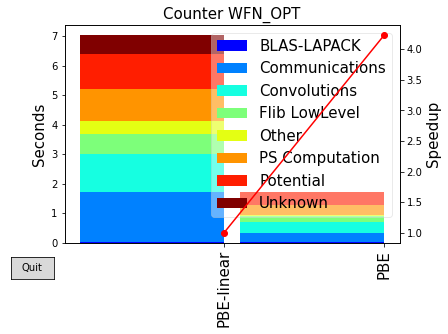

In [39]:
plot_timings(times)

For such a small system, we see that the Linear Scaling algorithm it is considerably slower than the cubic scaling one.
Each category of systems has a so-called "crossover point" in term of its number of atoms, after which the LS algorithm will become more convenient.

## Density of States

So far the only quantity we haven't looked at yet from the cubic scaling notebook is the DoS. This is deliberate - if you run the cell below, you will see that we get an error message.

In [40]:
from BigDFT.DoS import DoS
dos = DoS(logfiles_dict=logs)
dos.plot().legend(loc='best')

AttributeError: ignored

One of the parameters set by the `linear` profile is the `linear_method` keyword, which sets the approach used for kernel optimisation.

The linear scaling profile uses the Fermi Operator Expansion (FOE) approach, which is the recommended approach in most cases, particularly for very large systems. However, two other approaches are also available: direct minimisation of the Kohn Sham (KS) coefficients (DIRMIN), and diagonalisation (DIAG). These other approaches may be useful in different scenarios, as we will see.

Since FOE works directly with the density kernel, not the coefficients, in a standard calculation, we don't have access to the eigenvalues and hence cannot plot the DoS.  This is what the error message is telling us -- we don't have any `evals` which are the eigenvalues.

If we want to plot the DoS we could use the diagonalisation approach instead, or we can still use FOE, and just tell BigDFT to do a single diagonalisation at the end. Let's do that and rerun the calculation, by appending the calculation to the dataset.

In [41]:
# create again the input dictionary
inp = I.Inputfile()
inp.set_xc(functional)
inp.set_hgrid(0.4)
inp.set_psp_nlcc()
inp["import"] = "linear"    

# update the input dictionary by switching on subspace diagonalisation
inp.update({'lin_general': {'subspace_diag': True}})

# identify a name for the new run
run_name = 'H2O-1-PBE-linear-dos'
func_kwargs = dict(run_name=run_name, filename=filename, inp=dict(inp))

run_args = {}
run_args['jobname'] = run_name
run_args['mpi'] = 4
run_args['omp'] = 4
run_args['time'] = 2 # minutes

all_runs.append_run(args=func_kwargs, 
                    extra_files_recv=[run_name+'.tar.gz'],
                    **run_args)
run_names.append(run_name)   


As expected, we should see that two of the jobs are already submitted, so it's just the new calculation which should be submitted to the queue.

In [42]:
all_runs.run() 

run already completed, skipping
run already completed, skipping
run already completed, skipping


It should again be quick, so we can then fetch the results back.

In [43]:
if not in_colab:
  all_runs.fetch_results(ignore_errors=True)

In [44]:
energies = all_runs.results

Let's print the energies - we can see that the extra diagonalisation at the end of the run made negligible difference to the total energy, as we might expect.

In [45]:
print(energies)
print(energies[0] - energies[2])

[-17.601346664765046, -17.60611945369108, -17.60134666476504]
-7.105427357601002e-15


Let's also do the same processing steps as before.

In [46]:
# the data are unpacked in a "Calculations" subdirectory (see above arguments)
extract_results('H2O-linear-single')

# #patch the yaml files from a mistake in the case of low profiling depth
# !sed -i s/^\ *\:\ null/\ \ \ \ null/g H2O-linear-single/Calculations/time*

from BigDFT.Logfiles import Logfile as L
logs = {name.lstrip('H2O-1-'): L(join('H2O-linear-single','Calculations','log-'+name+'.yaml'))
        for name in run_names}

Finally let's look at the DoS. Note that the Fermi level is not automatically retrieved for LS-BigDFT, so we'll use the cubic scaling Fermi level.

We can see that the two DoS look very similar, albeit with a small shift. The cubic scaling case also does not have any empty states - this is because we did not explicitly ask for them. 

On the other hand, the LS empty states should not be relied upon for a standard LS calculation. In the case where they are required - it is possible to use the direct minimisation approach to optimise the support functions to represent some low energy virtual states. This is explained in the 4.C tutorial of the bigdft-school/CCP-tutorials repository.

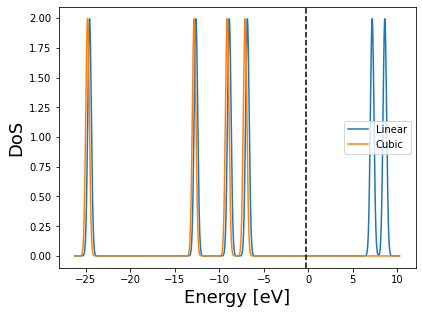

In [47]:
# here we modify the dict to ignore the initial LS calculation, and to rename the logs
dos = DoS(logfiles_dict={'Linear': logs['PBE-linear-dos'], 'Cubic': logs['PBE']},
          fermi_level=logs['PBE'].fermi_level)
dos.plot().legend(loc='best')

# Run of the full system

Let's now look at the full system, which we will again run using both cubic and LS BigDFT. To save compute time, we will skip the diagonalisation step, i.e. we will not be able to calculate the DoS.

We will use the same settings in terms of MPI and OpenMP as for the cubic notebook, but again changing the code to pass the input file directly to the function.

We will also increase the grid spacing to 0.5 - this is to allow us to explore the performance of a larger system (with more orbitals) without making the walltime too high.

Finally, since we want to measure the performance of the WFN_OPT section, we will furtherreduce the cost of the LS calculation by turning off matrix outputs, as well as the multipole calculation.

In [53]:
local_dir = 'H2O-linear-many'
remote_dir = f'/ceph/hpc/data/d2021-135-users/bigdft-school/{user}/H2O-many-LS' #use your own directory for new calculations
force_reinitialization = not in_colab # in case you rerun this cell multiple times
filename = 'H2O-32-free.xyz'
all_large_runs = Dataset(function = calculate_single_point,
                   url = url,
                   name = 'H2O-many-LS',
                   remote_dir = remote_dir,
                   local_dir = local_dir,
                   extra_files_send=filename,
                   block_reinit = force_reinitialization)

#we collect the run names for future reuse
large_run_names = []
# the we append the runs we would like to perform
for linear in [True, False]:
    #identify a name for the run
    run_name = '-'.join([filename.split('.')[0],functional] + (['linear'] if linear else []))
    
    # create a reasonable set of input parameters for the molecule - these are the same as the cubic scaling case
    inp = I.Inputfile()
    inp.set_xc(functional)
    inp.set_hgrid(0.5)
    inp.set_psp_nlcc()

    # activate the linear scaling mode if required
    if linear:
        inp["import"] = "linear"  
        inp.update({'lin_general': {'output_mat': 0, 'charge_multipoles': 0}})
    
    # we then pass the input dictionary to our function
    func_kwargs = dict(run_name=run_name, filename=filename, inp=dict(inp))
    

    run_args = {}
    run_args['jobname'] = run_name
    run_args['mpi'] = 32
    run_args['omp'] = 4
    run_args['time'] = 15 # minutes
    
    all_large_runs.append_run(args=func_kwargs, 
                        extra_files_recv=[run_name+'.tar.gz'],
                        **run_args)
    large_run_names.append(run_name)


In [54]:
all_large_runs.run()

run already completed, skipping
run already completed, skipping


These calculations will take slightly longer, so it may help to monitor the queue on Vega while they are running.

In [55]:
# while not all_large_runs.all_finished:
#     time.sleep(1)
if not in_colab:
  all_large_runs.fetch_results(ignore_errors=True)

Let's extract the results and plot a table of the times, as before. To avoid scrolling back and forth, we'll also reproduce the times for the single molecule.

Notice that even though the LS calculation is still slower than the cubic scaling calculation, the difference is much smaller. In other words, we are still below the crossover, but getting closer.

In [56]:
extract_results('H2O-linear-many')

In [57]:
large_logs = {name.lstrip('H2O-32-free-'): L(join('H2O-linear-many','Calculations','log-'+name+'.yaml'))
              for name in reversed(large_run_names)}

large_times = {name.lstrip('H2O-32-free-'): join('H2O-linear-many','Calculations','time-'+name+'.yaml')
              for name in large_run_names}

In [58]:
table=DataFrame({name:get_total_time_info(time) for name, time in large_times.items()}).T
table.round(3)

,INIT,WFN_OPT,LAST,Total,WFN_OPT %
PBE-linear,25.0,41.0,0.001,66.0,61.6
PBE,4.4,33.0,2.800,40.0,82.0


In [59]:
table=DataFrame({name:get_total_time_info(time) for name, time in times.items()}).T
table.round(3)

,INIT,WFN_OPT,LAST,Total,WFN_OPT %
PBE-linear,2.1,7.2,0.001,9.3,77.1
PBE,1.0,1.7,0.240,3.0,57.2


# Example plot of the Scaling

Finally, let's look in more detail about the scalability of the LS code. There are a few key details concerning the parallelisation of LS-BigDFT:
- GPUs: Not available with LS-BigDFT.
- OpenMP: Up to 8 threads can typically be used without too large a loss of efficiency, but for low memory nodes it may be necessary to use more threads to avoid under-occupying a node.
- MPI: MPI tasks are primarily parellelised over SFs (also in places over KS orbitals as in CS-BigDFT), so there is a strict maximum upper limit of MPI tasks which can be used. For best performance, it is better to have at leat 5-10 SFs per MPI.

We can check the parallelisation setup of the current runs by inspecting various useful fields of the LS logfile:

In [60]:
log = large_logs['PBE-linear']

print('MPI tasks = ',log.log['Number of MPI tasks'])
print('OpenMP threads = ',log.log['Maximal OpenMP threads per MPI task'])

print('Orbitals repartition', log.log['Orbitals Repartition'])
print('Support function repartition',log.log['Support Function Repartition'])

MPI tasks =  32
OpenMP threads =  4
Orbitals repartition {'MPI tasks  0- 31': 4}
Support function repartition {'Minimum': 5, 'Maximum': 8, 'Average': 6.0}


Above we can see the information about how many MPI tasks we used as well as how many threads per task - this agrees with what we requested. We can also see how both the orbitals and support functions are divided amongst MPI tasks - as an absolute minimum, each task should have at least one support function, but this will not be very efficient. Let's do a few final calculations with different number of MPI tasks in total, keeping the number of threads constant. For the sake of this tutorial, we will use a single node, but this can of course easily be generalised.

In [61]:
local_dir = 'H2O-linear-scaling'
remote_dir = f'/ceph/hpc/data/d2021-135-users/bigdft-school/{user}/H2O-scaling-LS' #use your own directory for new calculations

force_reinitialization = not in_colab # in case you rerun this cell multiple times
filename = 'H2O-32-free.xyz'
all_scaling_runs = Dataset(function = calculate_single_point,
                   url = url,
                   name = 'H2O-scaling-LS',
                   remote_dir = remote_dir,
                   local_dir = local_dir,
                   extra_files_send=filename,
                   block_reinit = force_reinitialization)
#we collect the run names for future reuse
scaling_run_names = []
# the we append the runs we would like to perform
for nmpi in [8, 16, 24, 32]:
    #identify a name for the run
    run_name = '-'.join([filename.split('.')[0],functional] + [str(nmpi)])
    
    # create a reasonable set of input parameters for the molecule - these are the same as the cubic scaling case
    inp = I.Inputfile()
    inp.set_xc(functional)
    inp.set_hgrid(0.5)
    inp.set_psp_nlcc()
    inp["import"] = "linear"  
    inp.update({'lin_general': {'output_mat': 0, 'charge_multipoles': 0}})
    
    # we then pass the input dictionary to our function
    func_kwargs = dict(run_name=run_name, filename=filename, inp=dict(inp))

    run_args = {}
    run_args['jobname'] = run_name
    run_args['mpi'] = nmpi
    run_args['omp'] = 4
    run_args['time'] = 15 # minutes
    
    all_scaling_runs.append_run(args=func_kwargs, 
                        extra_files_recv=[run_name+'.tar.gz'],
                        **run_args)
    scaling_run_names.append(run_name)    


In [62]:
all_scaling_runs.run()

run already completed, skipping
run already completed, skipping
run already completed, skipping
run already completed, skipping


Let's extract the results and make a simple plot of the scaling.

In [63]:
# while not all_scaling_runs.all_finished:
#     time.sleep(1)
if not in_colab:
  all_scaling_runs.fetch_results(ignore_errors=True)
all_scaling_energies=all_scaling_runs.results

In [64]:
extract_results('H2O-linear-scaling')

     
scaling_logs = {name: L(join('H2O-linear-scaling','Calculations','log-'+name+'.yaml'))
              for name in reversed(scaling_run_names)}
        
scaling_times = {name: join('H2O-linear-scaling','Calculations','time-'+name+'.yaml')
              for name in scaling_run_names}

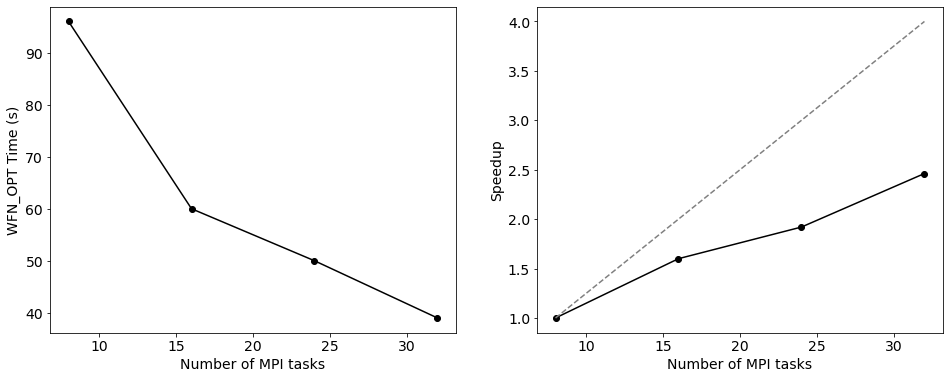

In [65]:
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1, 2, figsize=(16, 6))


wfn_opt_times = [{name:get_total_time_info(time) for name, time in scaling_times.items()}[name]['WFN_OPT']
                 for name in scaling_run_names]
nmpi = [scaling_logs[name].log['Number of MPI tasks'] for name in scaling_run_names]

ax = axs[0]
ax.plot(nmpi, wfn_opt_times, color='k', marker='o')
ax.set_ylabel('WFN_OPT Time (s)')
ax.set_xlabel('Number of MPI tasks')

ax = axs[1]
ax.plot(nmpi, [wfn_opt_times[0]/t for t in wfn_opt_times], color='k', marker='o')
# also plot the ideal speedup
ax.plot(nmpi, [n/nmpi[0] for n in nmpi], color='gray', ls='--')
ax.set_ylabel('Speedup')
ax.set_xlabel('Number of MPI tasks')

plt.show()

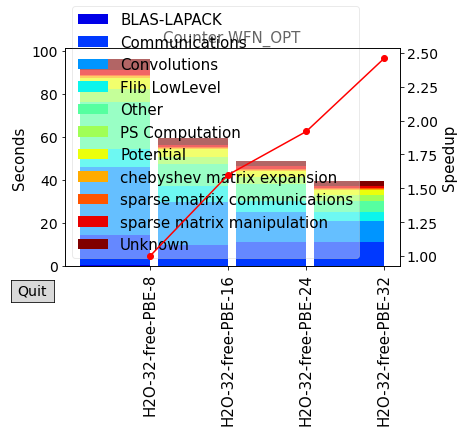

In [66]:
plot_timings(scaling_times)

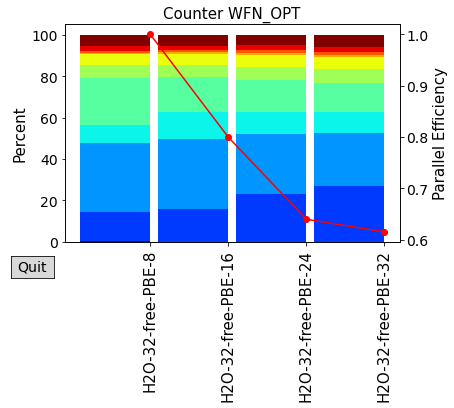

In [67]:
plot_timings(scaling_times,plottype='Percent',nokey=True)